In [83]:
import os, sys
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import math
import pydicom
import nibabel as nib
import torch
import h5py
import matplotlib.pyplot as plt

In [6]:
def get_file_list(path):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    files.sort()
    return files

def get_id_list(path):
    dirs = [f for f in listdir(path) if isdir(join(path, f))]
    dirs.sort()
    ids = [s.split('_')[1] for s in dirs]
    return ids

In [7]:
file_id = '030'
path_in = '/bmrNAS/people/arjun/data/qdess_knee_2020/files_recon_calib-16/'
filename = '{}MTR_{}.h5'.format(path_in, file_id)

f = h5py.File(filename, 'r')
print(f.keys())

<KeysViewHDF5 ['kspace', 'maps', 'target']>


- NOTE
    - each dcm alternates b/w t1, t2
        - that's why te alternates b/w [.006, .034]
        - dimn then makes sense, we have 320/2 = 160 slices of 512x512 each
    - `t2_map_wrapped = T2(t2_map_wrapped)` step is irrelevant
    - `tissue.add_quantitative_value(t2_map_wrapped)` step is irrelevant - adds the t2_map attribute to input tissue

In [13]:
# clipping bounds for t2
__T2_LOWER_BOUND__ = 0
__T2_UPPER_BOUND__ = 100
__T2_DECIMAL_PRECISION__ = 1  # 0.1 ms

__GL_AREA_TAG__ = pydicom.tag.Tag(0x001910b6)
__TG_TAG__ = pydicom.tag.Tag(0x001910b7)

path_segs = '/bmrNAS/people/akshay/dl/qdess_recon/segmentations/masks/'

- mask is a (512, 512, 160) int array w the following counts
    - array([[       0, 41561328],
       [       1,    49989],
       [       2,   198915],
       [       3,    34919],
       [       4,    39557],
       [       5,    32330],
       [       6,    26002]])
- doesn't seem to be lining up w the actual tissue, even if i flip it ud, lr, or ud+lr

0 001 0.02036 0.006428 None None


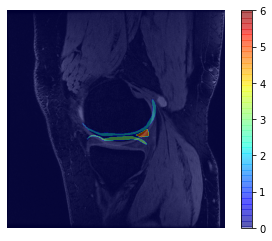

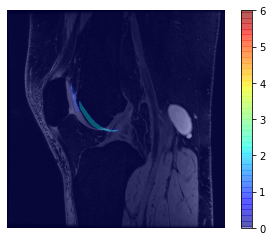

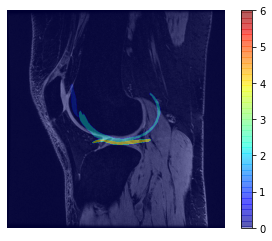

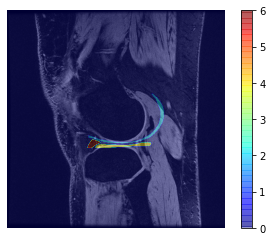

SystemExit: 

In [130]:
path_dcm = '/bmrNAS/people/akshay/dl/qdess_recon/segmentations/dicoms/'

file_id = '030'
idx_slice_list = [50, 80, 95, 110] # slices to plot

mask = nib.load(path_segs + 'MTR_{}.nii.gz'.format(file_id)).get_fdata().astype('int')
# mask = np.flip(mask,2)

file_id_list = get_id_list(path_dcm)

for file_id in file_id_list:

    path_mtr_dir = '{}MTR_{}/'.format(path_dcm, file_id)
    dcms_mtr = get_file_list(path_mtr_dir)

    for idx_d, d in enumerate(dcms_mtr):
        # goes from 0..319 for I001.dcm .. I320.dcm
        # idx_d=0 is I001.dcm is an echo1
        # idx_d=1 is I002.dcm is an echo2
        # ...
        # idx_d=168 is I167.dcm is an echo1

        ds = pydicom.dcmread(path_mtr_dir + d)
        
        tr = float(ds.RepetitionTime) * 1e-3
        te = float(ds.EchoTime) * 1e-3
        alpha = math.radians(float(ds.FlipAngle))

        try:
            tg = float(ds[0x001910b7].value) * 1e-6
        except KeyError:
            tg = None
        try:
            gl_area = float(ds[0x001910b6].value)
        except KeyError:
            gl_area = None

        if idx_d == 0:
            print(idx_d, file_id, tr, te, tg, gl_area)
        if idx_d > 0:
            if tg or gl_area:
                print(idx_d, tr, te, tg, gl_area)
                
        if idx_d % 2 == 0: # do only for echo1's
            idx_slice = idx_d // 2
            if idx_slice in idx_slice_list:
                                
                mask_slice = mask[:,:,idx_slice].astype('int')
                mask_slice = np.rot90(mask_slice, k=3)
#                 mask_slice = np.flipud(mask_slice)
                mask_slice = np.fliplr(mask_slice)

                plt.imshow(ds.pixel_array,cmap='gray')
                plt.imshow(mask_slice, cmap='jet', clim=(0,6), alpha=0.4)
                plt.colorbar()
                plt.axis('off')
                plt.show()
        
    sys.exit()

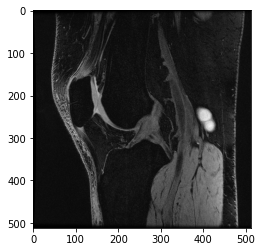

In [131]:
ds = pydicom.dcmread(path_mtr_dir + 'I167.dcm')
arr = ds.pixel_array

plt.imshow(arr,cmap='gray')

In [99]:
y = np.bincount(mask.flatten())
ii = np.nonzero(y)[0]

np.vstack((ii,y[ii])).T

array([[       0, 41561328],
       [       1,    49989],
       [       2,   198915],
       [       3,    34919],
       [       4,    39557],
       [       5,    32330],
       [       6,    26002]])